In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns 
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [17]:
species = "horse"
bed_file = 'horse/'+'sep1_244_sorted.bed' # all loci of TEs
results_file = 'horse/'+'v2output_sep1.txt' # VCF info for each sample that has SV at TE loci

In [18]:
colors = {'PRZEWALSKI' : 'red', 'AKHAL-TEKE' : 'blue', 'ARABIAN' : 'green', \
          'QUARTER HORSE' : 'yellow', "MONGOLIAN" : "brown", "THOROUGHBRED" : 'orange', \
          'FRIESIAN' : 'black', 'HANOVARIAN' : 'pink', 'JEJU HORSE' : 'gray', \
          'CURLY HORSE' : 'purple', 'DEBAO' : 'teal', 'CRIOLLO' : 'tan'}

In [19]:
# get all loci
entries = []
with open(bed_file) as f:
    lines = f.readlines()
    for line in lines: #
        line = line.split()
        end = int(line[1]) + int(line[2])
        t = ">"+line[0]+":"+line[1]+"-"+str(line[1])
        entries.append(t)

In [20]:
meta_data = pd.read_csv('horse/horse_sra_simple.csv')
meta_data.columns = ['sra','breed']
color_col = []
for index, row in meta_data.iterrows():
    row['breed'] = row['breed'] + str(random.randint(0,9))
    #row['breed'] = row['breed']
#row['color'] = color_col
    #print(meta_data)

In [21]:
samples = {}

with open(results_file) as f:
    lines = f.readlines()
    for line in lines:
        if "output" in line: # get sample name for each cluster
            sample_name = line.split('/')[1].strip() 
            breed_name = meta_data.loc[meta_data['sra'] == sample_name]
            #print(breed_name, sample_name)
            breed_name = breed_name['breed'].values[0]
            samples[breed_name] = np.zeros(len(entries)) 
        else: # if not a sample name then get vcf info
            t = line.split()
            chrom = t[0]
            start = t[1]
            end = start
            seq = re.search('SVINSSEQ=(.*);SPLIT_READS',line)
            seq = seq.group(1)
            s = ">"+chrom+":"+start+"-"+end
            if s in entries and chrom not in  ['X', 'Y']: # check which SV in reference to TE loci 
                idx = entries.index(s)
                samples[breed_name][idx] = 1
        

In [22]:
df=pd.DataFrame.from_dict(samples,orient='index').transpose()

In [23]:
#df = df.loc[:, ~df.columns.str.startswith('QUARTER')]
#df = df.loc[:, ~df.columns.str.startswith('FRIESIAN')]
#df = df.loc[:, ~df.columns.str.startswith('MONGOLIAN')]
#df = df.loc[:, ~df.columns.str.startswith('PRZ')]
#df = df.loc[:, ~df.columns.str.startswith('THOROUGH')]
#df = df.loc[:, ~df.columns.str.startswith('CRIOLLO')]
#df = df.loc[:, ~df.columns.str.startswith('DEBAO')]
#df = df.loc[:, ~df.columns.str.startswith('HANOV')]
#df = df.loc[:, ~df.columns.str.startswith('JEJU')]
#df = df.loc[:, ~df.columns.str.startswith('CURLY')]
#df = df.loc[:, ~df.columns.str.startswith('AKHAL')]
#df = df.loc[:, ~df.columns.str.startswith('ARAB')]

cols = list(df.columns.values)
cols = sorted(cols, key=str.lower)

In [24]:
df_new = df[cols]
df_final = df_new.iloc[0:900]

df_final = df_final.transpose()
#print(df_final.sum().values)
#print(df_final.sum().index)

In [25]:
#fig = plt.figure(figsize = (12, 5))

#plt.bar(df_final.sum()[500:600].index, df_final.sum()[500:600], color ='maroon',
#        width = 0.35)
 
#plt.xlabel("Loci")
#plt.ylabel("Frequency")
#plt.title("Random Loci Prevelance in Population")
#plt.show()

/Users/DBurke/anaconda3/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


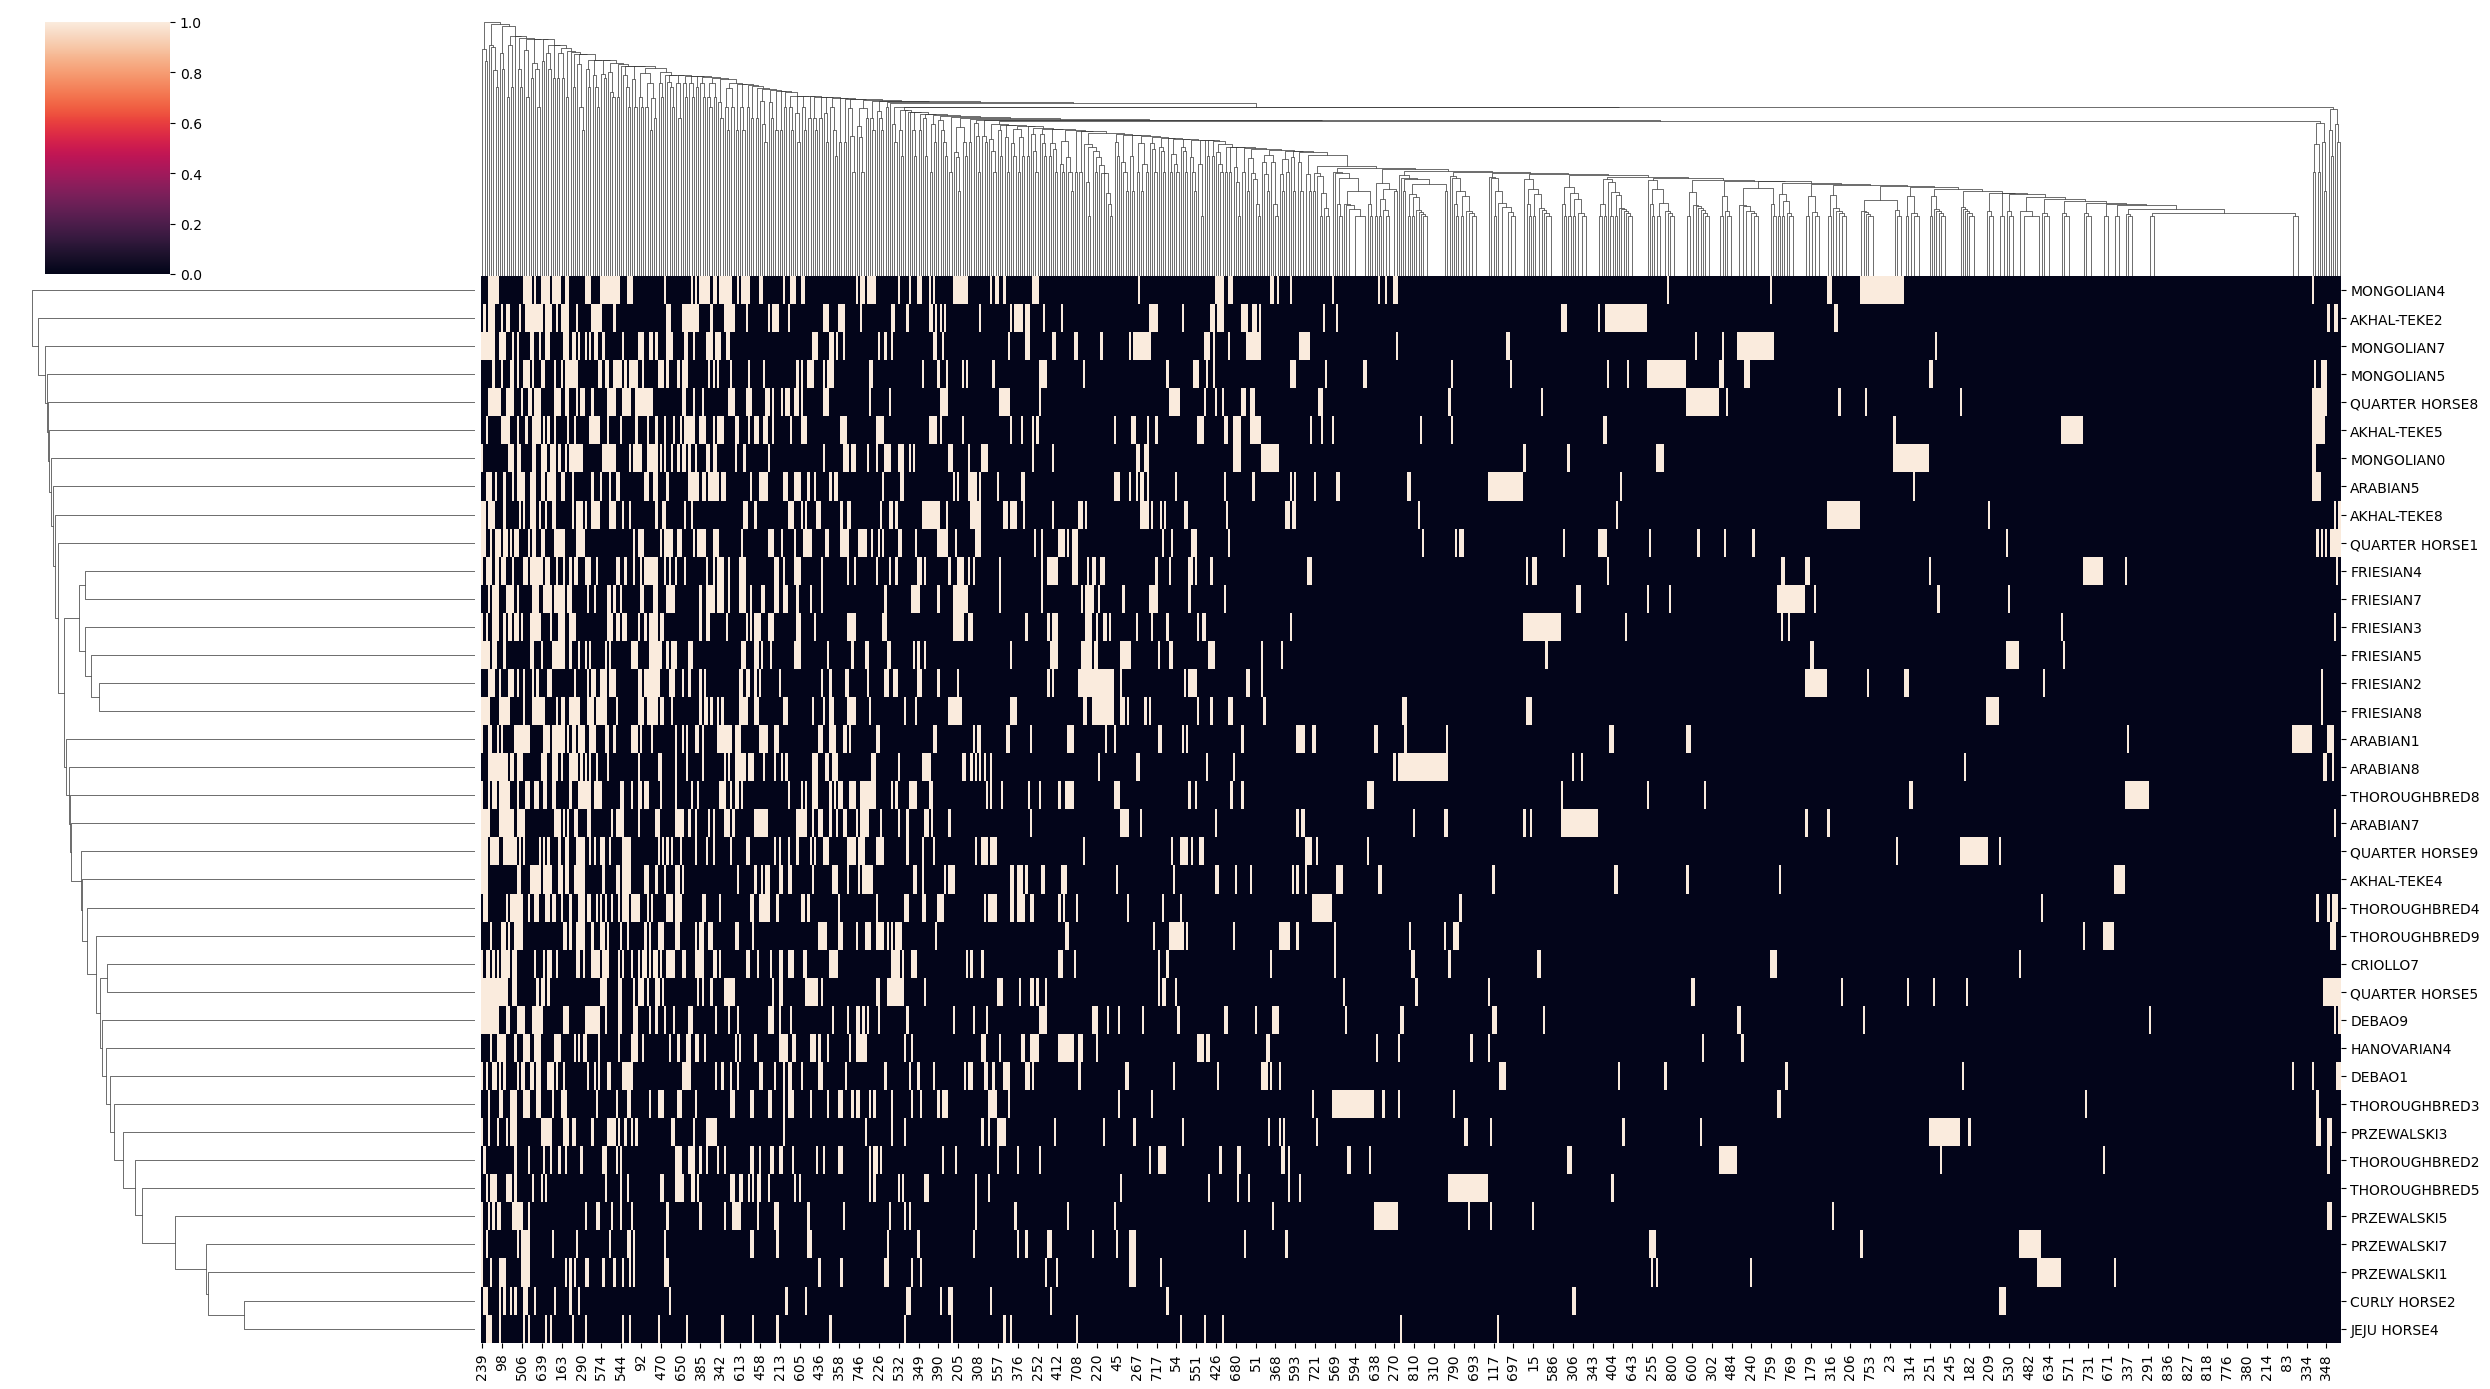

In [26]:
#plt.subplots(figsize=(25,15))
ls = sns.clustermap(df_final, cmap = 'rocket',figsize=(25,14))
fig = ls.fig
fig.savefig("binary.png") 

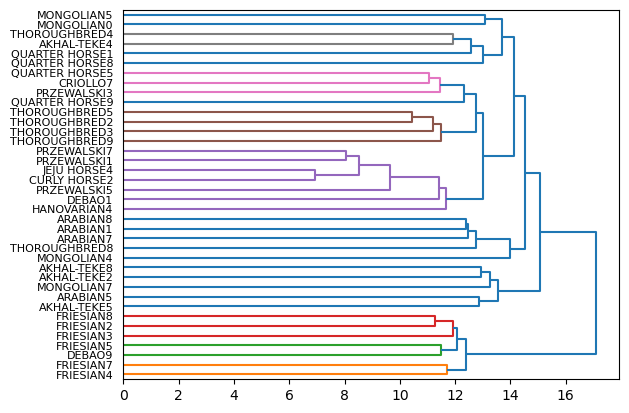

In [27]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
X = df_final.loc[:].values
y = list(df_final.index)
# Import the fcluster and linkage functions
from scipy.cluster.hierarchy import fcluster, linkage
 
distance_matrix = linkage(X, method = 'ward', metric = 'euclidean')
# Create a dendrogram
dn = dendrogram(distance_matrix, labels = y,  leaf_rotation= 0, leaf_font_size = 8, orientation = 'right')
 
# Display the dendogram
plt.show()

In [28]:
print(X)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [29]:
pca = PCA(n_components=2)
X = np.array(list(samples.values()))
y = list(samples.keys())
x_scaled = StandardScaler().fit_transform(X)
pca_features = pca.fit_transform(x_scaled)
pca_df = pd.DataFrame(
    data=pca_features, 
    columns=['PC1', 'PC2'])
pca_df['target'] = y
t = list(pca_df['target'].values)
cs = [colors[i[:-1]] for i in t] 
pca_df['colors'] = cs

In [30]:
X = df_final.loc[:].values
x_scaled = StandardScaler().fit_transform(X)
y = list(df_final.index)

pca_features = pca.fit_transform(x_scaled)
## Create dataframe
pca_df = pd.DataFrame(
    data=pca_features, 
    columns=['PC1', 'PC2'])
pca_df['target'] = y
t = list(pca_df['target'].values)
cs = [colors[i[:-1]] for i in t] 
pca_df['colors'] = cs
c_dict = dict(zip(pca_df.target, pca_df.colors))
print(pca_df)

          PC1        PC2          target  colors
0   -9.927414 -12.274459     AKHAL-TEKE2    blue
1   -4.042769  -1.321501     AKHAL-TEKE4    blue
2   -3.768883  -0.026808     AKHAL-TEKE5    blue
3   -3.453313  -5.394971     AKHAL-TEKE8    blue
4   -7.404498  -5.181535        ARABIAN1   green
5    0.282633   0.780955        ARABIAN5   green
6   -1.178845  -2.642897        ARABIAN7   green
7   -3.714731   4.573857        ARABIAN8   green
8    0.643811   0.059493        CRIOLLO7     tan
9   -0.516608  -0.126234    CURLY HORSE2  purple
10  -0.025147   1.114800          DEBAO1    teal
11   1.437887   0.283740          DEBAO9    teal
12  14.436099  -2.886745       FRIESIAN2   black
13  14.518673  -4.047951       FRIESIAN3   black
14  15.436916  -3.967216       FRIESIAN4   black
15   8.899012  -2.708436       FRIESIAN5   black
16  12.094859  -0.651295       FRIESIAN7   black
17  12.020351  -3.338359       FRIESIAN8   black
18  -2.692392   0.476068     HANOVARIAN4    pink
19  -0.813748  -0.04

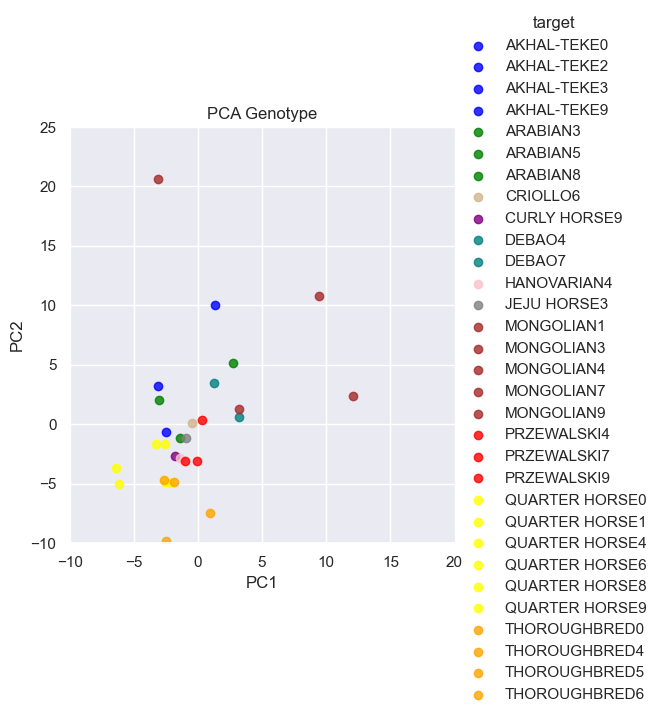

In [35]:
import seaborn as sns
sns.set()
 
ls = sns.lmplot(
    x='PC1', 
    y='PC2', 
    data=pca_df, 
    palette=c_dict,
    hue='target',
    fit_reg=False, 
    legend=True
    )
ls = (ls.set_axis_labels("PC1","PC2").set(xlim=(-10,20),ylim=(-10,25)))
plt.title('PCA ERE1 Type')
plt.title('PCA Genotype')
plt.show()